# NBoALSS HW 5



In [1]:
from nbaolss import *
import numpy as np
import scipy
import matplotlib.pyplot as plt

## a) Newton iterates to converge for $\varepsilon =0.01$ 

From the plot it is obvious to see that if we get close the the bifurcation at $\pi^2$, we need significantly more newton iterations for the method to converge.

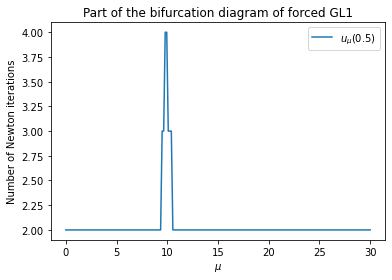

In [2]:
def forcing_fGL1(u, size, mu, epsilon):
    return (linGL1(size) @ u  + mu * (u  - u ** 3 / 3) + 
            epsilon * np.linspace(0, 1, size) * ( np.ones(size) - np.linspace(0, 1, size)))

def zero_of_forcing_GL1(u0, size, mu, epsilon):
    tol = 1e-6
    max_iter = 200
    l_fGL1 = lambda u: forcing_fGL1(u, size, mu, epsilon)
    l_JacGL1 = lambda u: JacGL1(u, size, mu)
    return newton(u0, l_fGL1, l_JacGL1, tol, max_iter)

def forcing_cont(mu, u0, mu_end, steps, epsilon):
    size = len(u0)
    mu_steps = np.linspace(mu, mu_end, steps)
    res = np.zeros((steps, size))
    iters = np.zeros(steps)
    res[0, :], iters[0] = zero_of_forcing_GL1(u0, size, mu_steps[0], epsilon)
    for step in range(1, steps):
        # Use the previous estimate as the new starting point
        res[step, :], iters[step] = zero_of_forcing_GL1(res[step - 1], size, mu_steps[step], epsilon)
    return res, iters

size = 100
epsilon = 0.01
mu_end = 30
steps = 200

mu_pts = np.linspace(0, mu_end, steps)
_, iters = forcing_cont(0, np.zeros(size), mu_end, steps, epsilon)
        
plt.plot(mu_pts, iters, label='$u_\mu (0.5)$')
plt.xlabel('$\mu$')
plt.ylabel('Number of Newton iterations')
plt.title('Part of the bifurcation diagram of forced GL1')
plt.legend()

## b) Switching to the negative branch

First we will try to find the negative branch in the obvious way: We guess that at $\mu = 20$, minus the function from the positive/easy branch is a good guess for the negative branch and start a parameter continuation from there.

In [3]:
# We will use data_0_20 and u05_0_20 for the rest of this assignment
size = 100
epsilon = 0.01
mu_start = 0
mu_end = 20
steps = 300
u05_0_20 = np.zeros(steps)

mu_pts_0_20 = np.linspace(mu_start, mu_end, steps)
data_0_20, iters = forcing_cont(mu_start, np.zeros(size), mu_end, steps, epsilon)

for step in range(0, steps):
    u05_0_20[step] = data_0_20[step, 50]

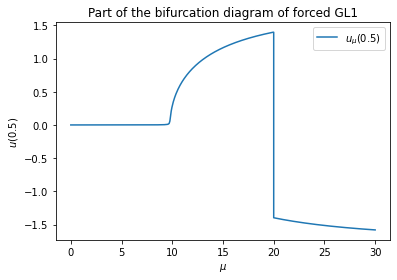

In [4]:
size = 100
epsilon = 0.01
mu_start = 20
mu_end = 30
steps = 300
u05_20_30 = np.zeros(steps)

mu_pts_20_30 = np.linspace(mu_start, mu_end, steps)
data2, iters2 = forcing_cont(mu_start, -data_0_20[-1], mu_end, steps, epsilon)

for step in range(0, steps):
    u05_20_30[step] = data2[step, 50]
    
mu_0_30 = np.concatenate((mu_pts_0_20, mu_pts_20_30))    
data_0_30 = np.concatenate((u05_0_20, u05_20_30))
plt.plot(mu_0_30, data_0_30, label='$u_\mu (0.5)$')
plt.xlabel('$\mu$')
plt.ylabel('$u(0.5)$')
plt.title('Part of the bifurcation diagram of forced GL1')
plt.legend()

## c) Continuation in $\varepsilon$

Next we take a bit more systematic approach. As before, we first keep $\varepsilon$ fixed and parameter continue to $\mu = 20$. Then we start a parameter continuation in $\varepsilon$, where we bring it back to $\varepsilon = 0$. At this point, we are at a perfect pitchfork bifurcation, so we know that there must be a negative branch. We then take minus the value we got at $\varepsilon$, use a parameter continuation to bring it back to $\varepsilon = 0.01$ and then use that value as a starting guess for the parameter contination in $\mu$ on $[20, 30]$.

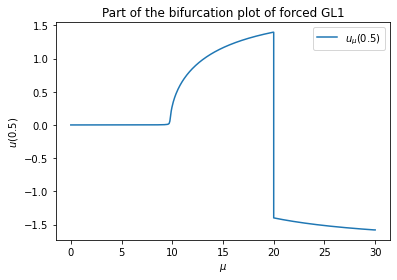

In [5]:
def forcing_cont_eps(epsilon, epsilon_end, mu, u0, steps):
    size = len(u0)
    epsilon_steps = np.linspace(epsilon, epsilon_end, steps)
    res = np.zeros((steps, size))
    res[0, :], _ = zero_of_forcing_GL1(u0, size, mu, epsilon_steps[0])
    for step in range(1, steps):
        # Use the previous estimate as the new starting point
        res[step, :], iters[step] = zero_of_forcing_GL1(res[step - 1], size, mu, epsilon_steps[step])
    return res

epsilon = 0.01
epsilon_end = 0
mu = 20
u0 = data_0_20[-1]
steps = 100

# First we bring epsilon to zero, so that we get to the perfect pichfork bifurcation point
data_eps = forcing_cont_eps(epsilon, epsilon_end, mu, u0, steps)

# Because we are at the pitchfork bifurcation, there must exist a negative branch
# So we are going to follow that one
u0 = -data_eps[-1]
data_eps_min = forcing_cont_eps(epsilon_end, epsilon, mu, u0, steps)

# And then finally use that to determine the negative branch 
# of the original imperfect pitchfork bifurcation
mu_start = 20
mu_end = 30
steps = 100
data_20_30, _ = forcing_cont(mu_start, data_eps_min[-1], mu_end, steps, epsilon)


u05_20_30 = np.zeros(steps)
mu_pts_20_30 = np.linspace(mu_start, mu_end, steps)
for step in range(0, steps):
    u05_20_30[step] = data_20_30[step, 50]

mu_0_30 = np.concatenate((mu_pts_0_20, mu_pts_20_30))    
data_0_30 = np.concatenate((u05_0_20, u05_20_30))
plt.plot(mu_0_30, data_0_30, label='$u_\mu (0.5)$')        
plt.xlabel('$\mu$')
plt.ylabel('$u(0.5)$')
plt.title('Part of the bifurcation plot of forced GL1')
plt.legend()

## d) Residue continuation 

Now we will use residue continuation to find the negative branch. For that we guess that minus the value we found at $\mu=20$ and $\varepsilon = 0.01$ is a guess for the negative branch. Let that guess be $x_G$, then we have the triple $(x_G, \mu, \epsilon)$. Define $r_G = \Phi(x_G; \mu, \epsilon)$, which is our residue. We then consider the global homotopy equation $\Phi(x; \mu, \epsilon) - (1-\alpha)r_G = 0$ for $\alpha \in [0, 1]$. By construction, we have that $x_G$ is a solution to this equation for $\alpha = 0$, which we will use to conduct a continuation in $\alpha$. Then, when we get to $\alpha = 1$ we have by construction a zero of $\Phi$, which we can use as a starting guess to find the negative branch.

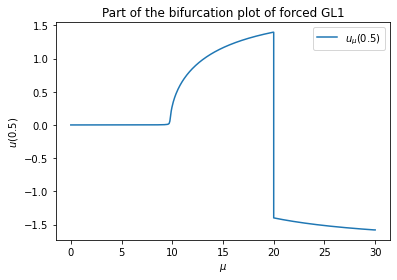

In [6]:
def forcing_fGL1_homotopy(u, size, mu, epsilon, alpha, residue):
    return (linGL1(size) @ u  + mu * (u  - u ** 3 / 3) + 
            epsilon * np.linspace(0, 1, size) * ( np.ones(size) - np.linspace(0, 1, size))
           - (1 - alpha) * residue)

def zero_of_forcing_GL1_homotopy(u0, size, mu, epsilon, alpha, residue):
    tol = 1e-6
    max_iter = 200
    l_fGL1 = lambda u: forcing_fGL1_homotopy(u, size, mu, epsilon, alpha, residue)
    l_JacGL1 = lambda u: JacGL1(u, size, mu)
    return newton(u0, l_fGL1, l_JacGL1, tol, max_iter)

def forcing_cont_homotopy(u0, steps, mu, epsilon):
    size = len(u0)
    alpha_steps = np.linspace(0, 1, steps)
    res = np.zeros((steps, size))
    res[0, :], iters[0] = zero_of_forcing_GL1_homotopy(u0, size, mu, epsilon,
                                                        alpha_steps[0], residue)
    for step in range(1, steps):
        # Use the previous estimate as the new starting point
        res[step, :], _ = zero_of_forcing_GL1_homotopy(res[step - 1], size, mu, 
                                                        epsilon, alpha_steps[step], residue)
    return res

size = 100
mu = 20
epsilon = 0.01
u0 = -data_0_20[-1]
steps = 100

# First we calculate the residue of our starting guess
residue = forcing_fGL1_homotopy(u0, size, mu, epsilon, 1, 0)
# Then we do a parameter continuation in alpha
data_alpha = forcing_cont_homotopy(u0, steps, mu, epsilon)

# We then take the last value (i.e. when alpha = 1, so Phi(u*; 20, 0.01) = 0)
# and then do a parameter continuation with this u* as a starting point
mu_start = 20
mu_end = 30
steps = 100
data_20_30, _ = forcing_cont(mu_start, data_alpha[-1], mu_end, steps, epsilon)


u05_20_30 = np.zeros(steps)
mu_pts_20_30 = np.linspace(mu_start, mu_end, steps)
for step in range(0, steps):
    u05_20_30[step] = data_20_30[step, 50]

mu_0_30 = np.concatenate((mu_pts_0_20, mu_pts_20_30))    
data_0_30 = np.concatenate((u05_0_20, u05_20_30))
plt.plot(mu_0_30, data_0_30, label='$u_\mu (0.5)$')
plt.xlabel('$\mu$')
plt.ylabel('$u(0.5)$')
plt.title('Part of the bifurcation plot of forced GL1')
plt.legend()


## Conclusions

* Near bifurcation points we need more Newton iterations
* For this specific problem, the naive guess, two parameter and residue continuation methods work well